In [15]:
import os
import math
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import random
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
import itertools

In [16]:
data_path = '/content/drive/MyDrive/Colab Notebooks/data_wav'  # data set uploaded to Google Drive, so we can make use of Google Colab GPU
track_length = 30                                      # track length is 30 seconds
s_r = 22050                                            # we ran librosa.load on single audio file to get the sample rate s_r
samples_per_track = s_r * track_length                 # total number of samples per track

In [17]:
def data_matrix(dataset_path,segment_count = 10, mfcc_count=13, n_fft=2048, hop_length=512):
  # We break down each track into segments so we have more data to work with. 
  # mfcc_count = No. of Mel-frequency cepstral coefficients
  # n_fft = length of the windowed signal after padding with zeros. Default = 2048

  X = []  # Data Matrix
  Y = []  # Label Matrix

  samples_per_segment = int(samples_per_track / segment_count)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

  for i, (root_path,folder_names,file_names) in enumerate(os.walk(dataset_path)):
    if root_path is dataset_path:
      continue
    else:
      for file_name in file_names:
        file_path = root_path + '/' + file_name
        signal, sample_rate = librosa.load(file_path, sr=s_r)

        for j in range(segment_count):
          begin = samples_per_segment*j
          end = samples_per_segment*(j+1)
          #mfcc = librosa.feature.mfcc(signal[begin:end], sample_rate, n_mfcc=mfcc_count, n_fft=n_fft, hop_length=hop_length)
          mfcc = librosa.feature.mfcc(signal[begin:end], sample_rate, n_fft=n_fft, hop_length=hop_length)
          mfcc = mfcc.T
          if len(mfcc) == num_mfcc_vectors_per_segment:
            mfcc_np = np.array(mfcc)
            X.append(mfcc_np)
            Y.append(i-1)
  return X,Y

In [18]:
genres = {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 
          'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}

In [5]:
x_arr,y_arr = data_matrix(data_path,segment_count = 10, n_fft=2048, hop_length=512)
X = np.array(x_arr)
Y = np.array(y_arr)

In [246]:
# Creating Training, Validation and Test Data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1,stratify = Y)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.1 ,stratify = Y_train)

# We have 1 channel in our case, so we need to add another axis on our data to indicate the channel
X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [247]:
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
num_output = 10

In [248]:
# CNN Model
model_cnn = keras.Sequential()

model_cnn.add(keras.layers.Conv2D(256, (3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

model_cnn.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

model_cnn.add(keras.layers.Conv2D(256, (2, 2), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(512, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))

model_cnn.add(keras.layers.Dense(10, activation='softmax'))

In [249]:

model_cnn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [250]:
model_cnn.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 128, 18, 256)      2560      
                                                                 
 max_pooling2d_71 (MaxPoolin  (None, 64, 9, 256)       0         
 g2D)                                                            
                                                                 
 batch_normalization_71 (Bat  (None, 64, 9, 256)       1024      
 chNormalization)                                                
                                                                 
 conv2d_77 (Conv2D)          (None, 62, 7, 256)        590080    
                                                                 
 max_pooling2d_72 (MaxPoolin  (None, 31, 4, 256)       0         
 g2D)                                                            
                                                     

In [251]:
#We use reduce_lr to reduce learning rate
reduce_lr = keras.callbacks.ReduceLROnPlateau( monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='min', min_delta=0.0001, cooldown=3, min_lr=1e-8
)
# We can use early stop when we see that our validation loss is increasing
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, mode='min')

In [252]:
history = model_cnn.fit(X_train, Y_train, validation_data=(X_validation, Y_validation), batch_size=32, epochs=50, callbacks=[reduce_lr])

Epoch 1/50
253/253 [==============================] - 11s 41ms/step - loss: 1.6283 - accuracy: 0.4691 - val_loss: 1.1034 - val_accuracy: 0.6144 - lr: 0.0010
Epoch 2/50
253/253 [==============================] - 10s 41ms/step - loss: 1.1302 - accuracy: 0.5954 - val_loss: 0.9657 - val_accuracy: 0.6789 - lr: 0.0010
Epoch 3/50
253/253 [==============================] - 10s 40ms/step - loss: 1.0007 - accuracy: 0.6491 - val_loss: 0.9804 - val_accuracy: 0.6511 - lr: 0.0010
Epoch 4/50
253/253 [==============================] - 10s 40ms/step - loss: 0.8328 - accuracy: 0.7096 - val_loss: 1.1793 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 5/50
253/253 [==============================] - 10s 39ms/step - loss: 0.7196 - accuracy: 0.7500 - val_loss: 0.7846 - val_accuracy: 0.7389 - lr: 0.0010
Epoch 6/50
253/253 [==============================] - 10s 40ms/step - loss: 0.5976 - accuracy: 0.7893 - val_loss: 0.7589 - val_accuracy: 0.7644 - lr: 0.0010
Epoch 7/50
253/253 [==============================] - 10s 

In [253]:
test_loss, test_acc = model_cnn.evaluate(X_test, Y_test, verbose=2)
print('Test accuracy:', test_acc)

32/32 - 1s - loss: 0.6648 - accuracy: 0.8810 - 520ms/epoch - 16ms/step

Test accuracy: 0.8809999823570251


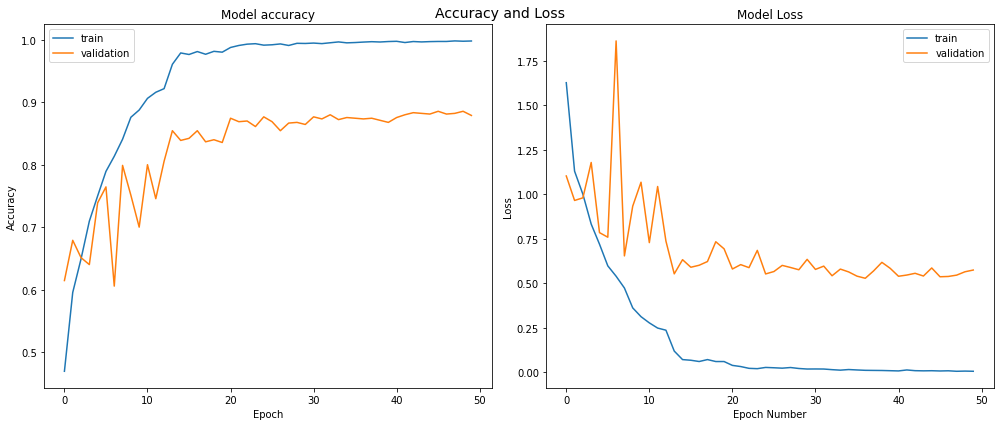

In [254]:
# Plotting Accuracy and Loss vs Epochs
figure = plt.figure(figsize=(14,6))
figure.suptitle('Accuracy and Loss', fontsize = 14)
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch Number')
plt.legend(['train', 'validation'], loc='upper right')
figure.tight_layout()
plt.show()

In [256]:
def plot_confusion_matrix(cm, classes,
                          title ,  
                          cmap=plt.cm.Oranges):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20,fontweight="bold")
    plt.xlabel('Predicted label',fontsize=20,fontweight="bold")
    plt.title('Confusion matrix ' + title  ,fontsize=20,fontweight="bold")

In [257]:
Y_pred = np.argmax(model_cnn.predict(X_test), axis = 1)
cm = confusion_matrix(Y_pred,Y_test)

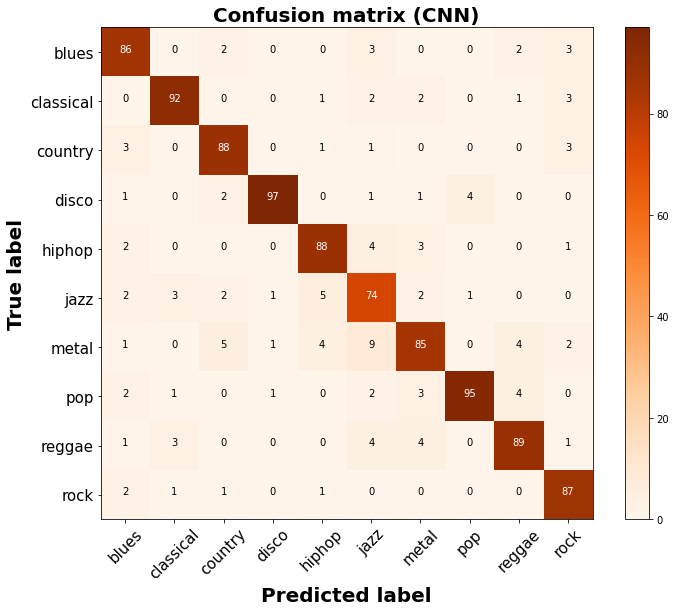

In [258]:
# Plotting confusion matrix 
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()
plt.figure(figsize=(10,8))       
plot_confusion_matrix(cm, keys , '(CNN)'  )

In [260]:
# LSTM Model
input_shape_LSTM = (X_train.shape[1], X_train.shape[2] )     

model_LSTM = keras.Sequential()

model_LSTM.add(keras.layers.LSTM(128, input_shape=input_shape_LSTM, return_sequences=True))
model_LSTM.add(keras.layers.LSTM(256))        

model_LSTM.add(keras.layers.Dense(128, activation='relu'))   
model_LSTM.add(keras.layers.Dropout(0.3))     
 
model_LSTM.add(keras.layers.Dense(10, activation='softmax'))

In [261]:
optimiser = keras.optimizers.Adam(learning_rate=0.001)
model_LSTM.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_LSTM.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 130, 128)          76288     
                                                                 
 lstm_19 (LSTM)              (None, 256)               394240    
                                                                 
 dense_60 (Dense)            (None, 128)               32896     
                                                                 
 dropout_36 (Dropout)        (None, 128)               0         
                                                                 
 dense_61 (Dense)            (None, 10)                1290      
                                                                 
Total params: 504,714
Trainable params: 504,714
Non-trainable params: 0
_________________________________________________________________


In [262]:
history = model_LSTM.fit(X_train, Y_train, batch_size=128, epochs= 100 )

Epoch 1/100
64/64 [==============================] - 9s 82ms/step - loss: 1.5795 - accuracy: 0.4314
Epoch 2/100
64/64 [==============================] - 5s 80ms/step - loss: 1.1950 - accuracy: 0.5746
Epoch 3/100
64/64 [==============================] - 5s 81ms/step - loss: 1.0322 - accuracy: 0.6459
Epoch 4/100
64/64 [==============================] - 5s 81ms/step - loss: 0.8682 - accuracy: 0.7057
Epoch 5/100
64/64 [==============================] - 5s 81ms/step - loss: 0.7989 - accuracy: 0.7317
Epoch 6/100
64/64 [==============================] - 5s 81ms/step - loss: 0.6735 - accuracy: 0.7787
Epoch 7/100
64/64 [==============================] - 5s 81ms/step - loss: 0.6525 - accuracy: 0.7815
Epoch 8/100
64/64 [==============================] - 5s 81ms/step - loss: 0.5586 - accuracy: 0.8186
Epoch 9/100
64/64 [==============================] - 5s 81ms/step - loss: 0.5191 - accuracy: 0.8270
Epoch 10/100
64/64 [==============================] - 5s 81ms/step - loss: 0.4259 - accuracy: 0.8592

In [263]:
test_loss, test_acc = model_LSTM.evaluate(X_test, Y_test, verbose=2)
test_acc_lstm_per = round(test_acc * 100,2)
print('\nTest accuracy:',test_acc_lstm_per, '%')

32/32 - 10s - loss: 0.6366 - accuracy: 0.8860 - 10s/epoch - 299ms/step

Test accuracy: 88.60 % 


In [265]:
Y_pred = np.argmax(model_LSTM.predict(X_test), axis = 1)
cm = confusion_matrix(Y_pred,Y_test)

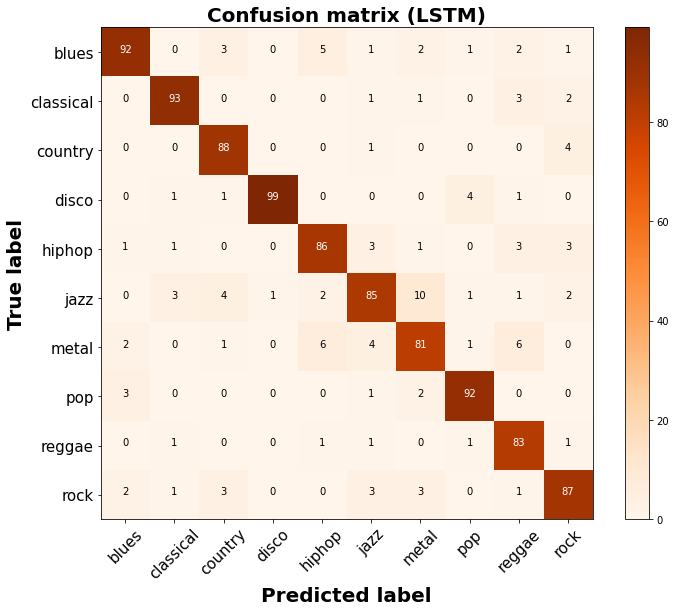

In [267]:
# Plotting confusion matrix 
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()
plt.figure(figsize=(10,8))       
plot_confusion_matrix(cm, keys , '(LSTM)'  )